In [1]:
import numpy as np
import pandas as pd
import math
import importlib
import detect_bursts
import matplotlib.pyplot as plt 

importlib.reload(detect_bursts)
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy.signal import find_peaks

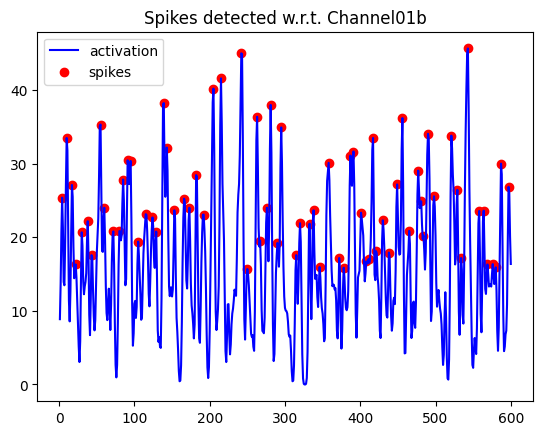

In [2]:
#read X.xlsx
X = pd.read_excel('X.xlsx',header=None)

X_time_series = X.iloc[1:,0].values
X_names = X.iloc[0,1:].values
X_timestamps = ['']*(X.shape[1]-1)
for item_index in range(X.shape[1]-1):
    X_activation = X.iloc[1:,item_index+1]
    X_timestamp_indices, _ = find_peaks(X_activation, height=X_activation.max()/3)
    X_timestamps[item_index] = [X_names[item_index],X_time_series[X_timestamp_indices]]
    #plot the spikes w.r.t. the current row 
    if item_index == 0:
        plt.plot(X_activation.index,X_activation.values,color = 'blue',label='activation')
        plt.scatter(X_activation.index[X_timestamp_indices],X_activation.values[X_timestamp_indices],color = 'red',label='spikes')
        plt.legend()
        plt.title(f'Spikes detected w.r.t. {X_names[0]}')
        plt.show()
X = pd.DataFrame(X_timestamps,columns=['name','timestamps'])



Load X

In [3]:
#within-burst number of spikes
def withinBurstNumSpikes(burstIndicator):
    num = len(np.where(burstIndicator == 1)[0])
    percentage = num/burstIndicator.shape[0]
    return num,percentage

#burst duration and inter-burst interval
def durations(timestamps,finalBurstRanges):
    burst = timestamps[finalBurstRanges[0][1]] - timestamps[finalBurstRanges[0][0]]
    #here we assume interBurst doesn't include the start-first-burst interval or the last-burst-end interval
    interBurstSt = finalBurstRanges[0][1]
    interBurst = 0

    maxSpikingFreq = (finalBurstRanges[0][1] - finalBurstRanges[0][0] + 1)/burst

    #tuple representing current burst
    for tup in finalBurstRanges[1:]:
        burstInc = timestamps[tup[1]] - timestamps[tup[0]]
        burst += burstInc
        interBurst += timestamps[tup[0]] - timestamps[interBurstSt]
        interBurstSt = tup[1]

        #count spikes within current burst
        curSpikingFreq = (tup[1]-tup[0]+1)/burstInc
        if maxSpikingFreq < curSpikingFreq:
            maxSpikingFreq = curSpikingFreq
            
    return burst,interBurst,maxSpikingFreq

#surprise values
def surpriseEval(finalBurstSurprises):
    meanSurprise = np.mean(finalBurstSurprises)
    maxSurprise = np.max(finalBurstSurprises)
    return meanSurprise,maxSurprise

#mean burst frequency
def meanBurstFreq(finalNumBursts,totalTime):
    meanburstFreq = finalNumBursts/totalTime
    # meanburstFreq = meanburstFreq* 1000
    return meanburstFreq

#render 9 parameters for each sample (1 trial of 1 neuron)
def renderParams(timestamps,finalBurstRanges,finalBurstSurprises,burstIndicator,finalNumBursts,totalTime):
    withinBurstSpikeNum,withinBurstSpikePercentage = withinBurstNumSpikes(burstIndicator)
    duration,interBurst,maxSpikingFreq = durations(timestamps,finalBurstRanges)
    meanSpikingFreq = withinBurstSpikeNum/duration
    meanSurprise,maxSurprise = surpriseEval(finalBurstSurprises)
    meanburstFreq = meanBurstFreq(finalNumBursts,totalTime)
    return [duration,meanSpikingFreq,maxSpikingFreq,withinBurstSpikeNum,\
            interBurst,withinBurstSpikePercentage,meanburstFreq,meanSurprise,maxSurprise]


def formulateDataset_unlabeled(totalDf,totalName = None,totalNeuron = None,totalStimuli = None,p = 0.5):
    sampleDataset = []
    nameRes = []
    timestampRes = []
    neuronRes = []
    stimuliRes = []

    no_burst_sampleDataset = []
    no_burst_nameRes = []
    no_burst_timestampRes = []
    no_burst_neuronRes = []
    no_burst_stimuliRes = []



    if totalName is None:
        totalName = ['']*(len(totalDf))

    
    if totalNeuron is None:
        totalNeuron = ['']*(len(totalDf))
    
    if totalStimuli is None:
        totalStimuli = ['']*(len(totalDf))
        
    for index,dfRow in enumerate(totalDf):
        lInput = [0] + dfRow
        burstIndicator,finalNumBursts,finalBurstRanges,finalBurstSurprises,totalTime = detect_bursts.detectBursts(lInput,0,math.inf,2,p)
        
        if finalBurstRanges != []:
            sampleDataset.append(renderParams(\
                lInput,finalBurstRanges,finalBurstSurprises,\
                    burstIndicator,finalNumBursts,totalTime))
            nameRes.append(totalName[index])
            neuronRes.append(totalNeuron[index])
            stimuliRes.append(totalStimuli[index])
            timestampRes.append(list(lInput))

        else:
            #no burst in current list of timestamps
            no_burst_sampleDataset.append(dfRow)
            no_burst_nameRes.append(totalName[index])
            no_burst_neuronRes.append(totalNeuron[index])
            no_burst_stimuliRes.append(totalStimuli[index])
            no_burst_timestampRes.append(list(lInput))
            

    return sampleDataset,nameRes,neuronRes,stimuliRes,timestampRes,\
        no_burst_sampleDataset,no_burst_nameRes,no_burst_neuronRes,no_burst_stimuliRes,\
        no_burst_timestampRes




#unsupervised -- save data into csv file
def saveData(Dataset,nameRes,neuronRes,stimuliRes,timestampRes):

    df = pd.DataFrame(Dataset,columns=\
                      ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
                       'within-burst number of spikes',\
                       'inter-burst interval','percentage of burst spikes','burst frequency',\
                        'mean surprise','max surprise'])
    
    #also include subject and stimuli name
    df['Subject'] = nameRes
    # df['Neuron'] = neuronRes
    # df['Stimuli'] = stimuliRes
    df['Timestamp'] = timestampRes
    
    # df.to_csv(savePath, index=False)
    return df


#neglect burst duration, within-burst spiking freq, and inter-burst interval in nine-cols
nine_cols = ['burst duration','within-burst spiking freq','within-burst max spiking freq',\
             'within-burst number of spikes',\
                'inter-burst interval','percentage of burst spikes','burst frequency',\
                'mean surprise','max surprise']


pruned_nine_cols = ['within-burst max spiking freq',\
                'within-burst number of spikes','percentage of burst spikes','burst frequency',\
                    'mean surprise','max surprise','label']

lr_opt = pickle.load(open('lr_opt.pkl', 'rb'))


def pred_X(X):
    X_timestamps = X.iloc[:,1]
    X_names = X.iloc[:,0]
    X_sampleDataset,X_nameRes,X_neuronRes,X_stimuliRes,X_timestampRes,\
        X_no_burst_sampleDataset,X_no_burst_nameRes,X_no_burst_neuronRes,\
            X_no_burst_stimuliRes,X_no_burst_timestampRes = formulateDataset_unlabeled(X_timestamps,X_names)

    X_df = saveData(X_sampleDataset,X_nameRes,X_neuronRes,X_stimuliRes,X_timestampRes)
    X_df_pruned = X_df[pruned_nine_cols[:-1]]

    X_pred = lr_opt.predict(X_df_pruned)
    X_pred = list(map(lambda x: 'LN' if x == 0 else 'PN',X_pred))
    X_df['prediction_label'] = X_pred

    #add no-burst samples to X_df, and label them as 'LN'
    X_no_burst = ['']*len(X_no_burst_sampleDataset)
    for index in range(len(X_no_burst_sampleDataset)):
        X_no_burst[index] = [np.nan]*(len(pruned_nine_cols)-1) + [X_no_burst_nameRes[index],\
                                X_no_burst_timestampRes[index],'LN']
        
        
    X_no_burst_df = pd.DataFrame(X_no_burst,columns=pruned_nine_cols[:-1]+['Subject','Timestamp','prediction_label'])
    X_df = pd.concat([X_df,X_no_burst_df],axis=0,ignore_index=True)

    #save to csv
    X_df.to_csv('X_parameters_and_prediction.csv', index=False)
    return X_df

X_df = pred_X(X)
display(X_df)


,burst duration,within-burst spiking freq,within-burst max spiking freq,within-burst number of spikes,inter-burst interval,percentage of burst spikes,burst frequency,mean surprise,max surprise,Subject,Timestamp,prediction_label
0,0.95,4.210526,4.210526,4.0,0.00,0.057143,0.033557,0.703506,0.703506,Channel01b,"[0.15, 0.45, 0.8, 1.05, 1.45, 1.85, 2.1, 2.7, ...",PN
1,0.50,6.000000,6.000000,3.0,0.00,0.051724,0.033670,0.658039,0.658039,Channel01c,"[0.4, 0.9, 1.1, 1.5, 1.75, 2.7, 3, 3.5, 4.5, 4...",PN
2,11.45,1.484716,1.791045,17.0,10.70,0.607143,0.102564,1.252241,1.551829,Channel01e,"[2.6, 3.4, 4.7, 7.15, 7.45, 7.6, 9, 9.2, 12, 1...",LN
3,4.10,1.707317,2.105263,7.0,16.30,0.318182,0.068611,1.015094,1.238976,Channel05c,"[0.35, 1.15, 4.75, 6.55, 6.95, 7.5, 10.4, 12.4...",PN
4,1.90,1.578947,1.578947,3.0,0.00,0.428571,0.055710,2.198427,2.198427,Channel05e,"[0.35, 8.95, 9.25, 12.45, 15.9, 17.65, 17.8, 1...",PN
5,3.60,3.333333,5.333333,12.0,9.55,0.210526,0.102564,0.893655,0.943438,Channel05f,"[0.25, 1.1, 1.5, 1.8, 2.65, 3, 4.15, 4.6, 4.8,...",PN
6,3.40,1.764706,2.068966,6.0,12.15,0.171429,0.067002,0.977684,1.091748,Channel05g,"[0.4, 1.35, 2.25, 2.6, 3.15, 3.3, 4.55, 5.75, ...",PN
7,3.60,1.666667,2.000000,6.0,11.00,0.315789,0.070175,1.095496,1.277000,Channel05h,"[4.4, 5.5, 9.1, 9.8, 12.65, 13.4, 15.15, 15.5,...",PN
8,4.80,1.250000,1.818182,6.0,22.30,0.428571,0.068143,0.891515,0.918404,Channel05i,"[0.4, 1.75, 2.05, 3, 9.8, 11.35, 17.75, 19.2, ...",PN
9,5.10,1.372549,2.000000,7.0,2.55,0.411765,0.067797,1.450010,1.464245,Channel05j,"[0.8, 4.25, 4.65, 9.65, 11, 11.15, 11.65, 12.2...",PN
